In [301]:
import pandas as pd

# Load the dataset
file_path = './data/train.csv'
data = pd.read_csv(file_path)

data['SalePrice']

# Display the first few rows of the dataset
# print(data.head())
# print(data.info())
# print(data.describe())


0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [302]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer


# Drop columns with more than 50% missing values
threshold = 0.5
missing_percentages = data.isnull().mean()
columns_to_drop = missing_percentages[missing_percentages > threshold].index
data = data.drop(columns=columns_to_drop)

# Handle remaining missing values

# Fill numerical columns with the median value
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

# Fill categorical columns with the mode value
# categorical_columns = data.select_dtypes(include=['object']).columns
# data[categorical_columns] = data[categorical_columns].apply(lambda x: x.fillna(x.mode()[0]))
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])

# Encode categorical variables
# encoder = LabelEncoder()
# for col in categorical_cols:
#     data[col] = encoder.fit_transform(data[col])
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_categorical_cols = pd.DataFrame(encoder.fit_transform(data[categorical_cols]),index=data.index)
encoded_categorical_cols.columns = encoder.get_feature_names_out(categorical_cols)
data = data.drop(columns=categorical_cols, axis=1).join(encoded_categorical_cols)

# Feature scaling
scaler = StandardScaler()
numeric_columns = [x for x in numeric_columns if x != 'SalePrice']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
print(type(data))

# Separate features and target
X = data.drop(['Id', 'SalePrice'], axis=1)  # Replace 'target_column' with the actual target column name
y = data['SalePrice']
print(X.shape)

<class 'pandas.core.frame.DataFrame'>
(1460, 233)


In [303]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [304]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
print(X_train_tensor.shape)

torch.Size([1168, 233])


In [305]:
class HousingPriceModel(nn.Module):
    def __init__(self, input_dim):
        super(HousingPriceModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [306]:
# class HousingPriceModel(nn.Module):
#     def __init__(self, input_dim):
#         super(HousingPriceModel, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 256)
#         self.fc2 = nn.Linear(256, 128)
#         self.fc3 = nn.Linear(128, 64)
#         self.fc4 = nn.Linear(64, 32)
#         self.fc5 = nn.Linear(32, 1)
        
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = torch.relu(self.fc3(x))
#         x = torch.relu(self.fc4(x))
#         x = self.fc5(x)
#         return x

In [307]:
# class HousingPriceModel(nn.Module):
#     def __init__(self, input_dim):
#         super(HousingPriceModel, self).__init__()
#         self.weights = nn.Parameter(torch.randn(input_dim, 1, dtype=torch.float), requires_grad=True)
#         self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)
#     def forward(self, x: torch.tensor) -> torch.tensor:
#         return torch.matmul(x, self.weights) + self.bias

In [308]:
# import torch.nn.init as init

# class HousingPriceModel(nn.Module):
#     def __init__(self, input_dim):
#         super(HousingPriceModel, self).__init__()
#         self.weights = nn.Parameter(torch.empty(input_dim, 1, dtype=torch.float))
#         self.bias = nn.Parameter(torch.empty(1, dtype=torch.float))

#         # Initialize weights using Xavier uniform initialization
#         init.xavier_uniform_(self.weights)
#         # Initialize bias with zeros or a small constant
#         init.zeros_(self.bias)

#     def forward(self, x: torch.tensor) -> torch.tensor:
#         return torch.matmul(x, self.weights) + self.bias

In [309]:
input_dim = X_train_tensor.shape[1]
model = HousingPriceModel(input_dim)

In [310]:
#for testing the random initialization
with torch.inference_mode():
    y_preds = model(X_train_tensor)
print(y_train_tensor[:5])
print(y_preds[:5])


tensor([[145000.],
        [178000.],
        [ 85000.],
        [175000.],
        [127000.]])
tensor([[0.1242],
        [0.0742],
        [0.1001],
        [0.1717],
        [0.1245]])


In [311]:

# Define loss function and optimizer
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [312]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [313]:

# # Parameters
# num_epochs = 5000

# # Tracking losses for visualization
# train_losses = []
# val_losses = []

# # Training loop
# for epoch in range(num_epochs):
#     model.train()
    
#     # Forward pass on the entire training set
#     predictions = model(X_train_tensor)
#     loss = criterion(predictions, y_train_tensor)
    
#     # Backward pass and optimization
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     # Record training loss
#     train_loss = loss.item()
#     train_losses.append(train_loss)
    
#     # Validation phase
#     model.eval()
#     with torch.no_grad():
#         val_predictions = model(X_val_tensor)
#         val_loss = criterion(val_predictions, y_val_tensor).item()
#         val_losses.append(val_loss)
    
#     if (epoch + 1) % 10 == 0:
#         print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# # Visualizing the training and validation loss
# plt.figure(figsize=(10, 5))
# plt.plot(train_losses, label='Training Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss Over Epochs')
# plt.legend()
# plt.show()

Epoch [10/2500], Training Loss: 15071.5459, Validation Loss: 85090.5469
Epoch [20/2500], Training Loss: 15071.5459, Validation Loss: 27904.2227
Epoch [30/2500], Training Loss: 15071.5459, Validation Loss: 23701.0469
Epoch [40/2500], Training Loss: 15071.5459, Validation Loss: 22446.3574
Epoch [50/2500], Training Loss: 15071.5459, Validation Loss: 21290.1230
Epoch [60/2500], Training Loss: 15071.5459, Validation Loss: 20710.4863
Epoch [70/2500], Training Loss: 15071.5459, Validation Loss: 20282.7031
Epoch [80/2500], Training Loss: 15071.5459, Validation Loss: 19993.4590
Epoch [90/2500], Training Loss: 15071.5459, Validation Loss: 19482.9023
Epoch [100/2500], Training Loss: 15071.5459, Validation Loss: 19283.7852
Epoch [110/2500], Training Loss: 15071.5459, Validation Loss: 19075.4082
Epoch [120/2500], Training Loss: 15071.5459, Validation Loss: 18994.5703
Epoch [130/2500], Training Loss: 15071.5459, Validation Loss: 18879.6797
Epoch [140/2500], Training Loss: 15071.5459, Validation Loss

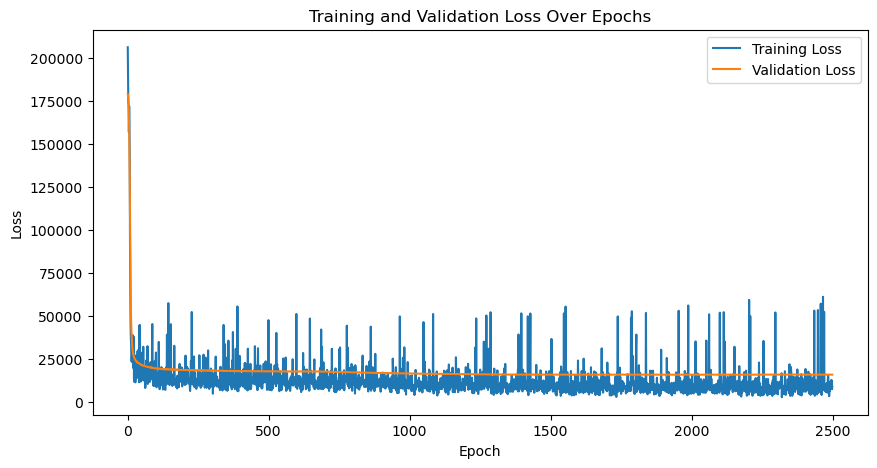

In [314]:
# Parameters
num_epochs = 2500

# Tracking losses for visualization
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # model.train()
    
    # # Forward pass on the entire training set
    # predictions = model(X_train_tensor)
    # loss = criterion(predictions, y_train_tensor)
    
    # # Backward pass and optimization
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()
    
    # # Record training loss
    # train_loss = loss.item()
    # train_losses.append(train_loss)
    
    # # Validation phase
    # model.eval()
    # with torch.no_grad():
    #     val_predictions = model(X_val_tensor)
    #     val_loss = criterion(val_predictions, y_val_tensor).item()
    #     val_losses.append(val_loss)
    
    # if (epoch + 1) % 10 == 0:
    #     print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # if (epoch+1) % 10 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        val_predictions = model(X_val_tensor)
        val_loss = criterion(val_predictions, y_val_tensor).item()
        val_losses.append(val_loss)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Visualizing the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [315]:
# model.eval()
# with torch.no_grad():
#     test_predictions = model(X_test_tensor)
#     test_loss = criterion(test_predictions, y_test_tensor)
#     print(f'Test Loss: {test_loss.item():.4f}')

In [316]:
import numpy as np
#test data processing
raw_test_data = pd.read_csv('./data/test.csv')
test_data = raw_test_data.drop(columns=columns_to_drop, axis=1)
numeric_columns = [x for x in numeric_columns if x != "SalePrice"]
test_data[numeric_columns] = test_data[numeric_columns].fillna(data[numeric_columns].median())

# Fill categorical columns with the mode value
# data[categorical_columns] = data[categorical_columns].apply(lambda x: x.fillna(x.mode()[0]))
test_data[categorical_cols] = categorical_imputer.fit_transform(test_data[categorical_cols])

# Encode categorical variables

# for col in categorical_cols:|
#     unseen_labels = set(test_data[col]) - set(encoder.classes_)
#     # Replace unseen labels with 'unknown' (or another special category)
#     test_data[col] = test_data[col].apply(lambda x: 'unknown' if x in unseen_labels else x)

#     # Optionally, add 'unknown' to the encoder's classes if needed
#     encoder.classes_ = np.append(encoder.classes_, 'unknown')

#     # Transform the test data using the same encoder
#     test_data[col] = encoder.transform(test_data[col])
#         # data[col] = encoder.transform(data[col])
encoded_categorical_cols = pd.DataFrame(encoder.transform(test_data[categorical_cols]),index=test_data.index)
encoded_categorical_cols.columns = encoder.get_feature_names_out(categorical_cols)
test_data = test_data.drop(columns=categorical_cols, axis=1).join(encoded_categorical_cols)

# Feature scaling
test_data[numeric_columns] = scaler.fit_transform(test_data[numeric_columns])

# Separate features and target
X_test = test_data.drop(['Id'], axis=1)  # Replace 'target_column' with the actual target column name
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)


In [317]:
model.eval()

with torch.inference_mode():
    predictions = model(X_test_tensor)
    print(predictions[:5])

tensor([[118606.5078],
        [161022.6250],
        [197005.0781],
        [209193.7344],
        [186918.4062]])


In [318]:
submission = pd.DataFrame({
    'Id': raw_test_data['Id'].astype('int32').values,  # The ID column from the test set
    'SalePrice': predictions.squeeze()  # The predicted values
})

submission.to_csv('submission.csv', index=False)